### Лабораторная работа №2
## Рекомендательные системы


In [1]:
%%capture
!pip install pandas

In [2]:
import pandas as pd

1. Выбрать датасет, подходящий для моделирования рекомендательной системы.  Хорошие источники данных: https://ods.ai/competitions/ и https://www.recsyschallenge.com/2025/ (тут можно подставлять любой год, начиная с 2016). Ещё примеры данных: https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset и https://boosters.pro/championship/rekko_challenge/data. Не рекомендуется брать данные с Kaggle, так как по ним часто уже есть готовый EDA и baseline. Запрещено брать датасет Movielens (любого размера).

Выбрал Avito Tech ML CUP 2025

clickstream.pq - история взаимодействия пользователей с объявлениями
- cookie - id пользователя [int64]
- item - id объявления [int64]
- event - id тип события [int64]. Например “клик”, “показать телефон”, “написать в мессенджер”
- event_date - время, когда пользователь провзаимодействовал с айтемом datetime[ns]
- surface  - экран, с которого было взаимодействие. Например пользователь может взаимодействовать с айтемом на поисковой выдаче, во вкладке “Избранное” [int64]
- platform -  тип устройства, с которого пользователь совершил действие. Например - android, ios, desktop, браузер в телефоне [int64]
- node - id группы товара [int64]

In [3]:
df_full = pd.read_parquet("data/lab-2/avito/clickstream.pq")
df_full.head()

,cookie,item,event,event_date,platform,surface,node
0,0,19915558,17,2025-02-05 02:30:59,3,2,115659
1,0,2680232,17,2025-01-24 21:16:57,3,2,115829
2,1,4247649,17,2025-01-29 23:00:58,2,2,7
3,1,4247649,17,2025-02-17 14:55:17,2,2,7
4,1,2171135,17,2025-01-17 19:23:29,2,2,214458


Засемплировал

In [4]:
df = df_full
users = df["cookie"].drop_duplicates().sample(frac=0.002, random_state=42)
df = df[df["cookie"].isin(users)].reset_index(drop=True)
df.shape

(113971, 7)

Разделил на train и test

In [5]:
from datetime import timedelta
EVAL_DAYS_TRESHOLD = 14
treshold = df['event_date'].max() - timedelta(days=EVAL_DAYS_TRESHOLD)
df_train = df[df['event_date'] <= treshold]
df_test = df[df['event_date'] > treshold][['cookie', 'item', 'event']]
df_train.shape

(79263, 7)

2. Сделать разведочный анализ данных (EDA), то есть посчитать статистические показатели, построить визуализации и дать им интерпретацию, подготовить отчёт по качеству данных (пропуски, дубли, выбросы). При необходимости предобработать данные. Сделать выводы. 

- cookie - id пользователя [int64]
- item - id объявления [int64]
- event - id тип события [int64]. Например “клик”, “показать телефон”, “написать в мессенджер”
- event_date - время, когда пользователь провзаимодействовал с айтемом datetime[ns]
- surface  - экран, с которого было взаимодействие. Например пользователь может взаимодействовать с айтемом на поисковой выдаче, во вкладке “Избранное” [int64]
- platform -  тип устройства, с которого пользователь совершил действие. Например - android, ios, desktop, браузер в телефоне [int64]
- node - id группы товара [int64]

In [6]:
%%capture
!pip install numpy

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = df_train

print("Размер данных:", df.shape)
print("\nИнформация о типах:")
print(df.info())


Размер данных: (79263, 7)

Информация о типах:
<class 'pandas.core.frame.DataFrame'>
Index: 79263 entries, 1 to 113968
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   cookie      79263 non-null  int64         
 1   item        79263 non-null  int64         
 2   event       79263 non-null  int64         
 3   event_date  79263 non-null  datetime64[ns]
 4   platform    79263 non-null  int64         
 5   surface     79263 non-null  int64         
 6   node        79263 non-null  uint32        
dtypes: datetime64[ns](1), int64(5), uint32(1)
memory usage: 4.5 MB
None


### Проверка пропусков и дубликатов

In [8]:
missing = df.isna().sum().sort_values(ascending=False)
print("Пропущенные значения:")
print(missing[missing > 0])

dupes = df.duplicated().sum()
print(f"Количество полных дубликатов: {dupes}")

Пропущенные значения:
Series([], dtype: int64)
Количество полных дубликатов: 480


Данные пригодны для анализа, необходимо только избавиться от небольшого числа дубликатов, а также привести типы, поскольку числа используются для обозначения категории.

In [9]:
df = df.drop_duplicates()
df["event_date"] = pd.to_datetime(df["event_date"], errors="coerce")
for col in df.columns:
    if col != "event_date":
        df[col] = df[col].astype("category")

C:\Users\niken\AppData\Local\Temp\ipykernel_22972\695820033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["event_date"] = pd.to_datetime(df["event_date"], errors="coerce")
C:\Users\niken\AppData\Local\Temp\ipykernel_22972\695820033.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("category")


### Диапазон дат

In [10]:
print("Минимальная дата:", df["event_date"].min())
print("Максимальная дата:", df["event_date"].max())

Минимальная дата: 2025-01-10 00:00:04
Максимальная дата: 2025-02-08 23:50:43


### Уникальные значения

In [11]:
cat_cols = [c for c in df.columns if c != "event_date"]

for col in cat_cols:
    print(f"{col}: {df[col].nunique()}")

cookie: 253
item: 52797
event: 16
platform: 6
surface: 17
node: 10581


### Распределение событий по дате

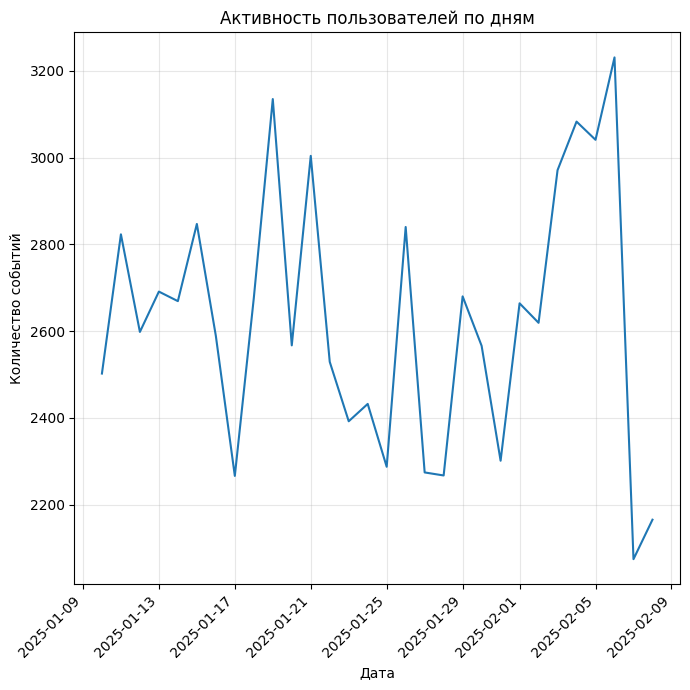

In [12]:
daily = df.set_index("event_date").resample("D").size()

plt.figure(figsize=(7, 7))
plt.plot(daily.index, daily.values, linewidth=1.5)
plt.title("Активность пользователей по дням")
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Распределение по времени суток и дню недели

C:\Users\niken\AppData\Local\Temp\ipykernel_22972\3387966275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour"] = df["event_date"].dt.hour.astype("category")
C:\Users\niken\AppData\Local\Temp\ipykernel_22972\3387966275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weekday"] = df["event_date"].dt.dayofweek.astype("category")


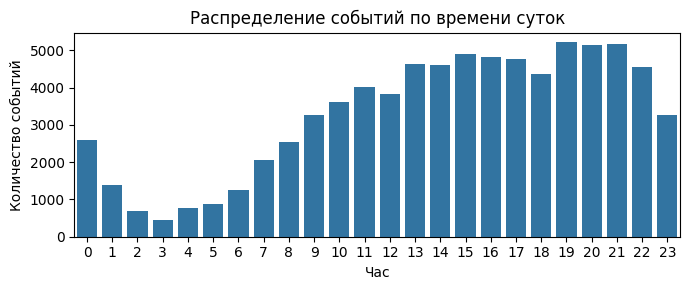

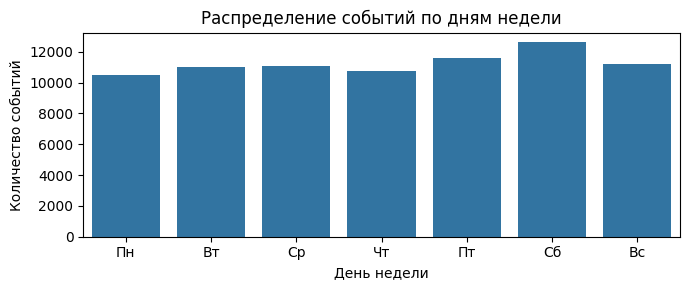

In [13]:
df["hour"] = df["event_date"].dt.hour.astype("category")
df["weekday"] = df["event_date"].dt.dayofweek.astype("category")

plt.figure(figsize=(7, 3))
sns.countplot(x="hour", data=df)
plt.title("Распределение событий по времени суток")
plt.xlabel("Час")
plt.ylabel("Количество событий")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 3))
sns.countplot(x="weekday", data=df)
plt.title("Распределение событий по дням недели")
plt.xlabel("День недели")
plt.ylabel("Количество событий")
weekday_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
plt.xticks(ticks=range(7), labels=weekday_labels)
plt.tight_layout()
plt.show()


### Частоты

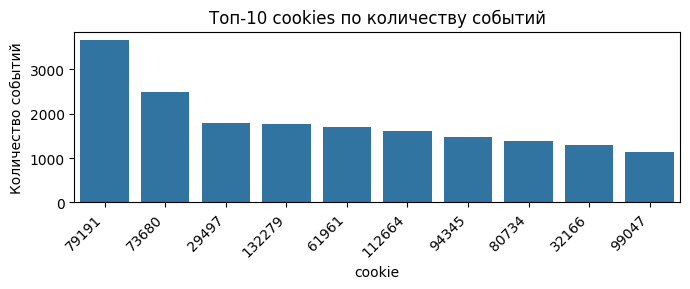

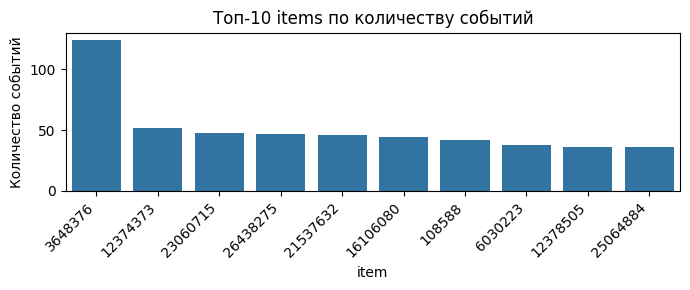

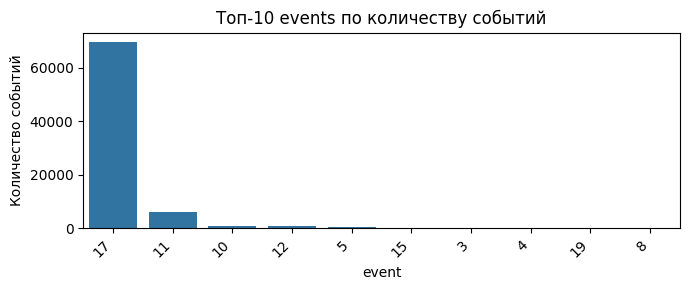

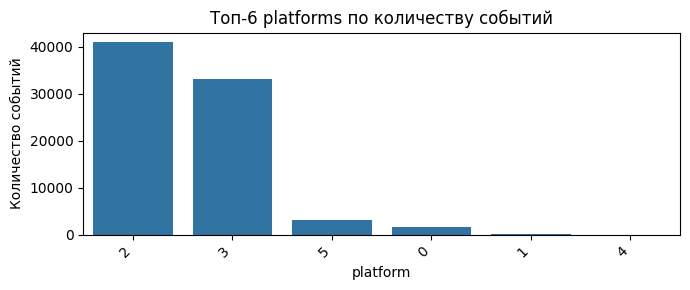

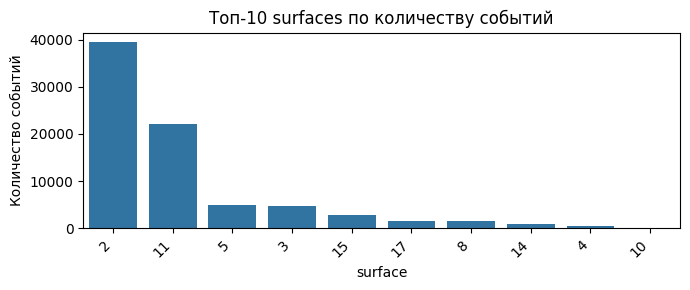

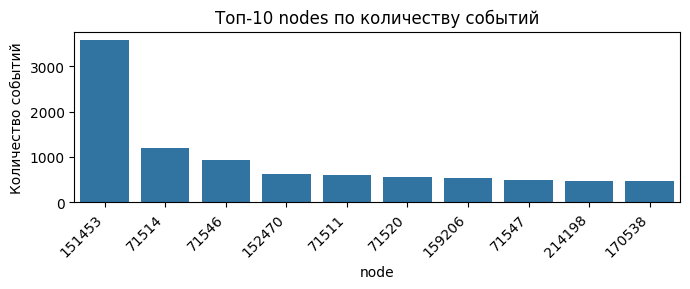

In [14]:
for col in cat_cols:
    top_vals = df[col].value_counts().head(10)
    plt.figure(figsize=(7, 3))
    sns.barplot(x=top_vals.index.astype(str), y=top_vals.values)
    plt.title(f"Топ-{min(10, len(top_vals))} {col}s по количеству событий")
    plt.xlabel(col)
    plt.ylabel("Количество событий")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Из диаграмм видно, что среди групп товаров а также событий выделяется по одному превалирующему типу. Среди устройств и страницы явно выделяется по два самых популярных типа. Для остальных признаков настолько резкого лидерства нет. 

### Активность пользователей

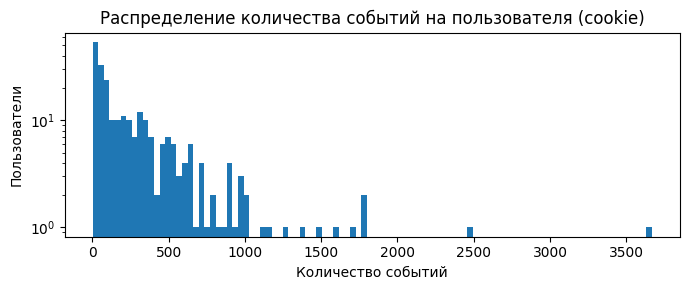


Статистика по активности пользователей:
count     253.000000
mean      311.395257
std       425.265540
min         1.000000
50%       169.000000
90%       746.800000
95%       992.400000
99%      1782.680000
max      3669.000000
dtype: float64


In [15]:
events_per_cookie = df.groupby("cookie").size()

plt.figure(figsize=(7, 3))
plt.hist(events_per_cookie, log=True, bins=100)
plt.title("Распределение количества событий на пользователя (cookie)")
plt.xlabel("Количество событий")
plt.ylabel("Пользователи")
plt.tight_layout()
plt.show()

print("\nСтатистика по активности пользователей:")
print(events_per_cookie.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))


Большинство пользователей совершают небольшое число взаимодействий, но небольшая доля очень активных пользователей создаёт значительный объём событий и очень сильно влияет на статитстику (скорее всего боты).
Медиана в два раза ниже среднего, что говорит о несимметричности распределения.
Пользователи с количеством событий выше персентиля 99% можем рассматривать как выбросы.

### Проверка на выбросы по активности

Используем метод межквартильного размаха и построим boxplot.

Ящик:
- Нижняя граница = 25-й перцентиль (Q1)
- Верхняя граница = 75-й перцентиль (Q3)

Линия внутри ящика = медиана (50-й перцентиль)

Усы:
- Нижний = Q1 − 1.5*IQR
- Верхний = Q3 + 1.5*IQR

Круги — выбросы.


Выбросов по активности пользователей: 13 (5.14%)


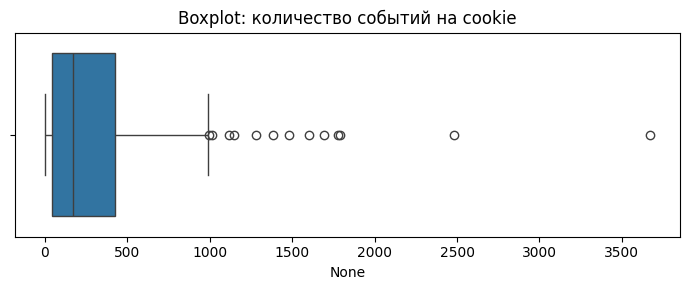

In [16]:
q1 = events_per_cookie.quantile(0.25)
q3 = events_per_cookie.quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
outliers = events_per_cookie[events_per_cookie > upper_bound]
print(f"\nВыбросов по активности пользователей: {len(outliers)} ({len(outliers)/len(events_per_cookie)*100:.2f}%)")

plt.figure(figsize=(7, 3))
sns.boxplot(x=events_per_cookie)
plt.title("Boxplot: количество событий на cookie")
plt.tight_layout()
plt.show()



Большая часть пользователей находится слева (~1000 событий).
Есть длинный «хвост» справа с пользователями, которые создают сильное смещение распределения.
По этому и предыдущему пункту можно сделать вывод, что данные необходимо отфильтровать от выбросов.

### Матрица корреляции (числовая кодировка категорий)

Данная матрица не отражает реальную зависимость категориальных признаков, потому что коды - произвольные числа, не имеющие количественного смысла, используем её только для приблизительной визуальной оценки (наличие дублирующих признаков).

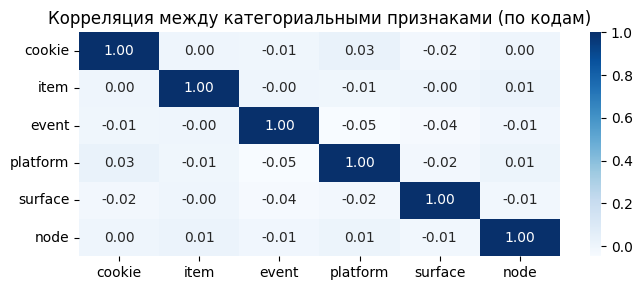

In [17]:
corr = df[cat_cols].corr()

plt.figure(figsize=(7, 3))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Корреляция между категориальными признаками (по кодам)")
plt.tight_layout()
plt.show()

Заметно отсутствие визуальной корреляции, исходя из чего можно сделать вывод об отсутствии дублирующих признаков.

### Итог

In [18]:
print("Строк:", len(df))
print("Пропусков:", df.isna().sum().sum())
print("Дубликатов:", dupes)
print("Диапазон дат:", df['event_date'].min(), "—", df['event_date'].max())
print("Выбросов по активности:", len(outliers))

Строк: 78783
Пропусков: 0
Дубликатов: 480
Диапазон дат: 2025-01-10 00:00:04 — 2025-02-08 23:50:43
Выбросов по активности: 13


Анализ показал, что данные набора распределены неравномерно, что соответствует ожиданиям. В данных присутствовали дубликаты. Также была обнаружена необходимоть в фильтрации выбросов. 

In [19]:
valid_cookies = events_per_cookie[events_per_cookie <= upper_bound].index

df = df[df["cookie"].isin(valid_cookies)]
df

,cookie,item,event,event_date,platform,surface,node,hour,weekday
1,482,16190773,11,2025-01-20 19:51:38,2,15,71520,19,0
2,482,16190773,17,2025-01-20 19:47:48,2,15,71520,19,0
3,482,16190773,17,2025-01-22 19:49:02,2,3,71520,19,2
4,482,16190773,17,2025-01-22 19:48:48,2,3,71520,19,2
5,482,18376224,17,2025-01-25 19:30:13,2,11,130589,19,5
...,...,...,...,...,...,...,...,...,...
113964,147699,11382318,17,2025-01-22 08:41:49,2,2,116128,8,2
113965,147699,6002070,17,2025-02-04 15:55:15,2,2,116123,15,1
113966,147699,15143620,17,2025-02-08 17:59:10,2,2,116118,17,5
113967,148579,11751522,17,2025-01-23 15:57:14,2,2,196650,15,3


In [20]:
df_test = df_test[df_test["cookie"].isin(valid_cookies)]

3. Выбрать минимум три метода формирования рекомендации. Реализовать их. Рекомендуемые методы: MostPop, UserKNN, ItemKNN, SLIM, EASE, ALS. При выборе методов старайтесь брать методы из разных семейств. 

In [21]:
events = pd.read_parquet("data/lab-2/avito/events.pq")
df = df.merge(events[['event', 'is_contact']], on='event', how='left')
df['is_contact'] = df['is_contact'].fillna(0).astype(int)
random_user = df['cookie'].drop_duplicates().sample(n=1, random_state=42).iloc[0]

f"Случайный пользователь: {random_user}"

'Случайный пользователь: 27648'

In [22]:
def most_pop(cookie, df, n = 10, exclude_seen = True):
    if exclude_seen:
        df = df.loc[df["cookie"] != cookie]

    return df.groupby(by='cookie')['is_contact'].sum().nlargest(n).index.tolist()

In [23]:
most_pop(random_user, df)

[134475, 115587, 70508, 123346, 74680, 83239, 143032, 482, 85436, 51448]

In [24]:
def build_user_item_pivot(df):
    df_pivot = (
        df.pivot_table(
            index='cookie',
            columns='item',
            values='is_contact',
            aggfunc='sum',
            fill_value=0
        )
    )
    pivot = df_pivot.to_numpy()
    
    cookies = df_pivot.index.to_numpy()
    items = df_pivot.columns.to_numpy()
    return pivot, cookies, items

In [25]:
pivot, cookies, items = build_user_item_pivot(df)

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

def user_knn(cookie, n = 10, exclude_seen = True, k = 5):
    idx = np.where(cookies == cookie)[0][0]

    target_vector = pivot[idx].reshape(1, -1)
    
    similarities = cosine_similarity(target_vector, pivot)[0]
    similarities[idx] = 0
    
    neighbors_idx = np.argsort(similarities)[-k:]
    neighbor_vectors = pivot[neighbors_idx]
    neighbor_sims = similarities[neighbors_idx]
    weighted_scores = np.dot(neighbor_sims, neighbor_vectors)
    
    if exclude_seen:
        seen_items = pivot[idx] > 0
        weighted_scores[seen_items] = -np.inf

    top_items_idx = np.argsort(weighted_scores)[-n:][::-1]
    return top_items_idx


In [27]:
user_knn(random_user)


array([52796, 17597, 17607, 17606, 17605, 17604, 17603, 17602, 17601,
       17600], dtype=int64)

In [28]:
%%capture
!pip install implicit

In [29]:
from implicit.als import AlternatingLeastSquares
import scipy.sparse as sp

In [30]:
user_item_matrix = sp.csr_matrix(pivot)
model = AlternatingLeastSquares(
    factors = 30,
    regularization = 0.1,
    iterations = 20,
    random_state = 42
)

model.fit(user_item_matrix.T)

def als(cookie, n = 10, model=model, exclude_seen = True):
    idx = np.where(cookies == cookie)[0][0]

    rec_ids, rec_scores = model.recommend(
        userid=idx,
        user_items=user_item_matrix.T.tocsr(),
        N=(n + np.count_nonzero(pivot[idx])) if exclude_seen else n,
        filter_already_liked_items=False
    )

    if exclude_seen:
        seen_items = np.where(pivot[idx] > 0)[0]
        rec_ids = np.setdiff1d(rec_ids, seen_items, assume_unique=True)

    top_items_idx = rec_ids[:n]
    return items[top_items_idx]

c:\Users\niken\AppData\Local\Programs\Python\Python38\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
c:\Users\niken\AppData\Local\Programs\Python\Python38\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0012824535369873047 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [31]:
als(random_user)

array([17925, 17893, 16729, 16232, 14938, 14398, 12703, 11692, 11500,
       10963], dtype=int64)

4. Выбрать не менее трёх метрик оценки качества рекомендаций. Рассчитать их. Желательно выбирать хотя бы одну метрику, учитывающую качество ранжирования. Желательно выбрать хотя бы одну специфическую для рекомендательных систем метрику (новизна, разнообразие, неожиданность).

In [32]:
def extract_test_recommendation(df, n = 10):
    grouped = df.groupby(['cookie', 'item'])['is_contact'].sum().reset_index()

    top_items = grouped.sort_values(['cookie', 'is_contact'], ascending=[True, False])
    top_items = top_items.groupby('cookie').head(n)

    counts = top_items.groupby('cookie')['item'].count()
    valid_cookies = counts[counts == n].index

    top_items = top_items[top_items['cookie'].isin(valid_cookies)]

    recommendations = top_items.groupby('cookie')['item'].apply(list).to_dict()

    return recommendations

df_test = df_test.merge(events[['event', 'is_contact']], on='event', how='left')
df_test['is_contact'] = df_test['is_contact'].fillna(0).astype(int)

Точность - доля релевантных среди найденных

In [33]:
def precision_at_k(test_recommendations, pred_recomendations):
    return sum([len(set(test_recommendations[cookie]) & set(pred_recomendations[cookie]))/len(set(pred_recomendations[cookie])) for cookie in test_recommendations.keys()]) / len(test_recommendations.keys())

Полнота - доля найденных среди релевантных

In [34]:
def recall_at_k(test_recommendations, pred_recomendations):
    return sum([len(set(test_recommendations[cookie]) & set(pred_recomendations[cookie]))/len(set(test_recommendations[cookie])) for cookie in test_recommendations.keys()]) / len(test_recommendations.keys())

Покрытие - доля объектов, которые хотя бы раз побывали среди рекомендованных

In [35]:
def coverage(all_items, pred_recomendations):
    i_p = set()
    for cookie in pred_recomendations.keys():
        i_p = i_p | set(pred_recomendations[cookie])
    return len(i_p) / len(all_items)

In [36]:
n = 10
recommendations = extract_test_recommendation(df_test, n=n)
all_items = df_full['item'].drop_duplicates()

MostPop

In [37]:
most_pop_rec = {cookie: most_pop(cookie, df, n) for cookie in recommendations.keys()}
precision = precision_at_k(recommendations, most_pop_rec)
recall = recall_at_k(recommendations, most_pop_rec)
cov = coverage(all_items, most_pop_rec)

print(f"Precision@{n}: {precision:.20f}")
print(f"Recall@{n}: {recall:.20f}")
print(f"Coverage: {cov:.20f}")

Precision@10: 0.00000000000000000000
Recall@10: 0.00000000000000000000
Coverage: 0.00000048572217459937


UserKNN

In [38]:
user_knn_rec = {cookie: user_knn(cookie, n) for cookie in recommendations.keys()}
precision = precision_at_k(recommendations, user_knn_rec)
recall = recall_at_k(recommendations, user_knn_rec)
cov = coverage(all_items, user_knn_rec)

print(f"Precision@{n}: {precision:.20f}")
print(f"Recall@{n}: {recall:.20f}")
print(f"Coverage: {cov:.20f}")

Precision@10: 0.00000000000000000000
Recall@10: 0.00000000000000000000
Coverage: 0.00000097144434919874


ALS

In [39]:
als_rec = {cookie: als(cookie, n) for cookie in recommendations.keys()}
precision = precision_at_k(recommendations, als_rec)
recall = recall_at_k(recommendations, als_rec)
cov = coverage(all_items, als_rec)

print(f"Precision@{n}: {precision:.20f}")
print(f"Recall@{n}: {recall:.20f}")
print(f"Coverage: {cov:.20f}")

Precision@10: 0.00053763440860215054
Recall@10: 0.00053763440860215054
Coverage: 0.00000353252490617724


5. Сформулировать предложения по улучшению качества рекомендаций. Сделать выводы.

MostPop лучше всего использовать там, где присутствует проблема "холодного старта", посколькку он дает неперсонализированные результаты. Метрики Precision и Recall равны нулю, так как, видимо, популярные товары не пересекаются с тестовыми событиями. Coverage почти нулевой — система рекомендует очень мало уникальных товаров. У UserKNN проблемы с сильно разреженными данными, которые характерны для clickstream датасетов, в связи с чем косинусное расстояние почти всегда нулевое. ALS лучше справляется с разреженной матрицей, так как строит скрытые факторы, но качество всё ещё низкое.

- Решить проблему с ОЗУ и увеличить объем сэмплирования
- Исключить товары с крайне низкой частотой, чтобы алгоритмы обучались на более значимых взаимодействиях
- Использовать гибридные модели из комбинаций MostPop, UserKNN, ALS
- Узнать значения лейблов, для задания экспертами осмысленных весов